In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import StandardScaler

def get_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = get_device()
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0)}")


# https://www.kaggle.com/datasets/alistairking/weather-long-term-time-series-forecasting?resource=download

def load_timeseries_data(file_path, device=None, exclude_columns=None, target_column=None):
    """
    Load time series data from CSV file into a tensor format and move to specified device.
    
    Parameters:
    -----------
    file_path : str or Path
        Path to the CSV file
    device : torch.device or None
        Device to move tensors to. If None, uses get_device()
    exclude_columns : list or None
        List of column names to exclude from features
    target_column : str or None
        If specified, separates this column as the target variable
        
    Returns:
    --------
    features : torch.Tensor
        Tensor of shape (time_steps, n_features) on specified device
    target : torch.Tensor or None
        If target_column specified, returns tensor of shape (time_steps, 1) on specified device
    metadata : dict
        Dictionary containing dataset information
    scaler : StandardScaler
        Fitted scaler object for inverse transformation if needed
    """
    # Set device if not provided
    if device is None:
        device = get_device()
    
    # Ensure file path is Path object
    file_path = Path(file_path)
    
    # Check if file exists
    if not file_path.exists():
        raise FileNotFoundError(f"No file found at {file_path}")
    
    # Default columns to exclude if none specified
    if exclude_columns is None:
        exclude_columns = ['date']
    
    try:
        # First try standard CSV reading
        df = pd.read_csv(file_path, parse_dates=['date'])
    except Exception as e:
        # If that fails, try with space delimiter
        try:
            df = pd.read_csv(file_path, delim_whitespace=True, parse_dates={'date': [0, 1]})
        except Exception as nested_e:
            raise Exception(f"Failed to load data: {str(nested_e)}")
    
    # Sort by date to ensure temporal ordering
    df = df.sort_values('date')
    
    # Separate target if specified
    target = None
    if target_column:
        if target_column not in df.columns:
            raise ValueError(f"Target column '{target_column}' not found in data")
        target = df[target_column].values
        exclude_columns = exclude_columns + [target_column]
    
    # Get feature columns (excluding specified columns)
    feature_columns = [col for col in df.columns if col not in exclude_columns]
    
    # Extract features
    features = df[feature_columns].values
    
    # Check for and handle missing values
    if np.isnan(features).any():
        print(f"Warning: Found {np.isnan(features).sum()} missing values. Filling with forward fill, then backward fill.")
        features_df = pd.DataFrame(features, columns=feature_columns)
        features_df = features_df.fillna(method='ffill').fillna(method='bfill')
        features = features_df.values
    
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Convert to PyTorch tensors and move to device
    features_tensor = torch.FloatTensor(features_scaled).to(device)
    target_tensor = torch.FloatTensor(target).reshape(-1, 1).to(device) if target is not None else None
    
    # Create metadata dictionary
    metadata = {
        'feature_names': feature_columns,
        'num_features': len(feature_columns),
        'num_timesteps': len(df),
        'date_range': (df['date'].min(), df['date'].max()),
        'sampling_rate': pd.to_timedelta(df['date'].diff().mode().iloc[0]),
        'device': str(device)
    }
    
    # Print device information
    print(f"\nData loaded successfully to {device}")
    if torch.cuda.is_available():
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"Memory Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
    
    if target_tensor is not None:
        return features_tensor, target_tensor, metadata, scaler
    else:
        return features_tensor, metadata, scaler


def display_dataset_info(metadata):
    """
    Display information about the loaded dataset.
    
    Parameters:
    -----------
    metadata : dict
        Dictionary containing dataset metadata
    """
    print("\nDataset Information:")
    print("-" * 50)
    print(f"Number of time steps: {metadata['num_timesteps']}")
    print(f"Number of features: {metadata['num_features']}")
    print(f"Date range: {metadata['date_range'][0]} to {metadata['date_range'][1]}")
    print(f"Sampling rate: {metadata['sampling_rate']}")
    print(f"Device: {metadata['device']}")
    print("\nFeatures:")
    for i, feature in enumerate(metadata['feature_names'], 1):
        print(f"{i:2d}. {feature}")
    print("-" * 50)

# Helper function to move data between devices
def move_to_device(tensor, device):
    """
    Move a tensor or collection of tensors to specified device.
    
    Parameters:
    -----------
    tensor : torch.Tensor or collection of tensors
        Data to move to device
    device : torch.device
        Target device
        
    Returns:
    --------
    Tensor or collection of tensors on specified device
    """
    if isinstance(tensor, (list, tuple)):
        return [move_to_device(t, device) for t in tensor]
    return tensor.to(device)



class LTC(nn.Module):
    def __init__(self, input_features, hidden_features, output_features, tau, A, step_size):
        super().__init__()
        
        self.A = A
        self.tau = tau  
        self.step_size = step_size        
        
        self.input_features = input_features
        self.hidden_features = hidden_features
        self.output_features = output_features
        combined_size = input_features + hidden_features
        
        # InternalMLP for the LTC
        self.internalMLP = nn.Sequential(
            nn.Linear(combined_size, hidden_features),
            # nn.Sigmoid(),
            # nn.Linear(hidden_features, hidden_features),
            nn.ReLU(), 
        )
        
        for param in self.internalMLP[0].parameters():
            param.requires_grad = False

        # ReadoutMLP
        self.readoutMLP = nn.Sequential(
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, output_features),
        )
        
        self.to(device)
        
    def forward_input(self, input):
        
        timesteps, features = input.shape
        
        # Create initial hidden states (tensor of zeros)
        hidden_states = torch.zeros(timesteps, self.hidden_features).to(device)
    
        prev_hidden_state = torch.zeros(self.hidden_features).to(device)
        
        for timestep in range(timesteps):
            concat_input = torch.concat((input[timestep], prev_hidden_state), dim=0)
            function_output = self.internalMLP(concat_input) 
            
            # Fused Step
            num = prev_hidden_state + self.step_size * function_output * self.A
            den = 1 + self.step_size * (1/self.tau + 0.000001 + function_output)
            
            new_hidden_state = num / den
            
            hidden_states[timestep] = new_hidden_state
            prev_hidden_state = new_hidden_state
                
        # Create prediction placeholder
        predictions = torch.zeros(timesteps, self.output_features).to(device)
        
        for timestep in range(timesteps):
            predictions[timestep] = self.readoutMLP(hidden_states[timestep])
        
        return predictions, hidden_states
    
    def forward_hidden_states(self, hidden_states):
        
        timesteps, features = hidden_states.shape
        
        # Create prediction placeholder
        predictions = torch.zeros(timesteps, self.output_features).to(device)
        
        for timestep in range(timesteps):
            predictions[timestep] = self.readoutMLP(hidden_states[timestep])
        
        return predictions
                



Using device: cuda:0
Device name: NVIDIA GeForce RTX 2080 Ti


In [2]:
# Load data directly to the specified device
features, metadata, scaler = load_timeseries_data(
    r"D:\Programming\Python\Pytorch\Datasets\Weather\cleaned_weather.csv",
    device=device
)

# Display dataset information including device
display_dataset_info(metadata)


Data loaded successfully to cuda:0
GPU Name: NVIDIA GeForce RTX 2080 Ti
Memory Allocated: 4.02 MB
Memory Cached: 20.00 MB

Dataset Information:
--------------------------------------------------
Number of time steps: 52696
Number of features: 20
Date range: 2020-01-01 00:10:00 to 2021-01-01 00:00:00
Sampling rate: 0 days 00:10:00
Device: cuda:0

Features:
 1. p
 2. T
 3. Tpot
 4. Tdew
 5. rh
 6. VPmax
 7. VPact
 8. VPdef
 9. sh
10. H2OC
11. rho
12. wv
13. max. wv
14. wd
15. rain
16. raining
17. SWDR
18. PAR
19. max. PAR
20. Tlog
--------------------------------------------------


In [3]:
# Simple split without extra info
training = features[:int(features.shape[0] * 0.8)]  # First 80%
testing = features[int(features.shape[0] * 0.8):]   # Last 20%

print(training.shape)
print(testing.shape)

torch.Size([42156, 20])
torch.Size([10540, 20])


In [4]:
model = LTC(input_features=20,
            hidden_features=30,
            output_features=20,
            tau=0.9,
            A=5,
            step_size=10 # 10 minutes
            )

In [5]:
with torch.no_grad():
    predictions, hidden_sequence = model.forward_input(training)


torch.Size([42156, 30])


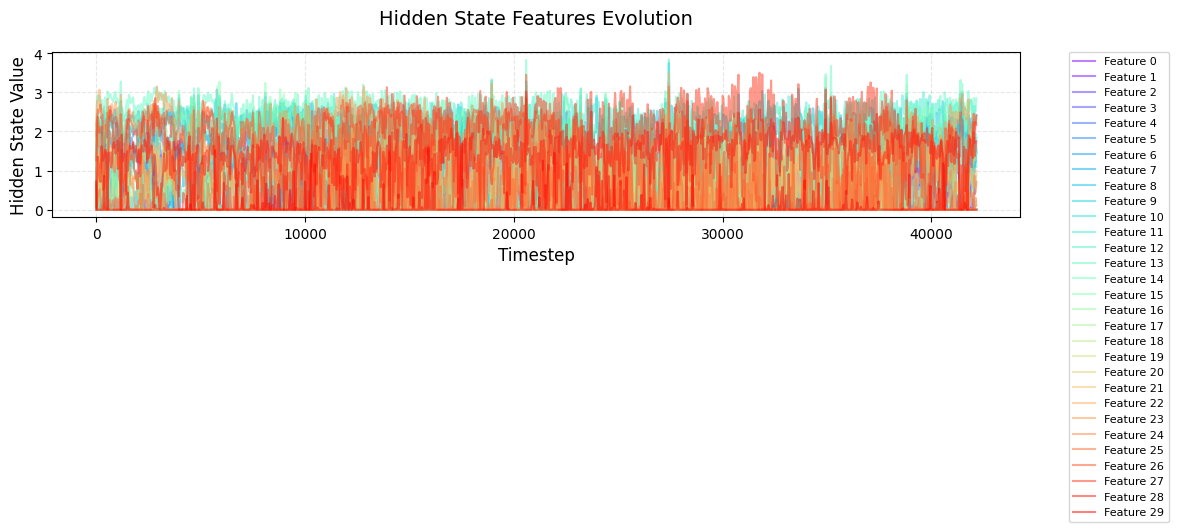

In [6]:
print(hidden_sequence.shape)

def plot_hidden_states(hidden_sequence, sample_size=1000, figsize=(15, 8), 
                      alpha=0.5, title="Hidden State Features Evolution"):
    """
    Plot the evolution of hidden state features over time.
    
    Parameters:
    -----------
    hidden_sequence : torch.Tensor
        Tensor of shape (timesteps, hidden_features)
    sample_size : int
        Number of timesteps to sample for visualization (to avoid overcrowding)
    figsize : tuple
        Figure size as (width, height)
    alpha : float
        Transparency of lines
    title : str
        Plot title
    """
    # Move tensor to CPU and convert to numpy if necessary
    if hidden_sequence.is_cuda:
        hidden_sequence = hidden_sequence.cpu()
    hidden_np = hidden_sequence.detach().numpy()
    
    # Sample timesteps if sequence is too long
    timesteps = hidden_np.shape[0]
    if timesteps > sample_size:
        indices = np.linspace(0, timesteps-1, sample_size, dtype=int)
        hidden_np = hidden_np[indices]
    
    # Create time points
    time_points = np.linspace(0, timesteps, hidden_np.shape[0])
    
    # Create color map for lines
    colors = plt.cm.rainbow(np.linspace(0, 1, hidden_np.shape[1]))
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot each hidden feature
    for i in range(hidden_np.shape[1]):
        plt.plot(time_points, hidden_np[:, i], 
                label=f'Feature {i}', 
                color=colors[i], 
                alpha=alpha)
    
    # Customize plot
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Timestep', fontsize=12)
    plt.ylabel('Hidden State Value', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Add legend in separate box to the right
    plt.legend(bbox_to_anchor=(1.05, 1), 
              loc='upper left', 
              borderaxespad=0.,
              fontsize=8)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    plt.show()
    
    
plot_hidden_states(hidden_sequence, figsize=(12,4))

In [7]:
optimiser = torch.optim.Adamax(model.parameters(), lr=0.03)
criterion = nn.MSELoss()

clipped_training = training[1:]

for epoch in range(15):
    
    optimiser.zero_grad()
    
    predictions = model.forward_hidden_states(hidden_sequence)
    
    clipped_predictions = predictions[:-1]  

    loss = criterion(clipped_predictions, clipped_training)
    loss.backward()
    optimiser.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss}\n")

Epoch 1, Loss: 1.3014843463897705

Epoch 2, Loss: 1.0377448797225952

Epoch 3, Loss: 0.9515255689620972

Epoch 4, Loss: 0.8610280156135559

Epoch 5, Loss: 0.7707501649856567

Epoch 6, Loss: 0.6982079744338989

Epoch 7, Loss: 0.6403849124908447

Epoch 8, Loss: 0.5994793772697449

Epoch 9, Loss: 0.5706766843795776

Epoch 10, Loss: 0.5461254715919495

Epoch 11, Loss: 0.518434464931488

Epoch 12, Loss: 0.48859521746635437

Epoch 13, Loss: 0.46040087938308716

Epoch 14, Loss: 0.4373922348022461

Epoch 15, Loss: 0.41961991786956787



In [8]:
with torch.no_grad():
    predictions = model.forward_hidden_states(hidden_sequence)

def plot_predictions_vs_labels(predictions, labels, feature_names=None, 
                             sample_size=1000, n_cols=3, figsize=(15, 4)):
    """
    Plot predictions against labels for each feature.
    
    Parameters:
    -----------
    predictions : torch.Tensor
        Tensor of shape (timesteps, features)
    labels : torch.Tensor
        Tensor of shape (timesteps, features)
    feature_names : list or None
        List of feature names. If None, will use numbered features
    sample_size : int
        Number of timesteps to sample for visualization
    n_cols : int
        Number of columns in the subplot grid
    figsize : tuple
        Base figure size (will be adjusted based on number of features)
    """
    # Move tensors to CPU and convert to numpy if needed
    if predictions.is_cuda:
        predictions = predictions.cpu()
    if labels.is_cuda:
        labels = labels.cpu()
        
    preds_np = predictions.detach().numpy()
    labels_np = labels.detach().numpy()
    
    # Verify shapes match
    assert preds_np.shape == labels_np.shape, "Predictions and labels must have same shape"
    
    # Sample timesteps if sequence is too long
    if preds_np.shape[0] > sample_size:
        indices = np.linspace(0, preds_np.shape[0]-1, sample_size, dtype=int)
        preds_np = preds_np[indices]
        labels_np = labels_np[indices]
    
    # Create time points
    time_points = np.linspace(0, predictions.shape[0], preds_np.shape[0])
    
    # Calculate grid layout
    n_features = preds_np.shape[1]
    n_rows = int(np.ceil(n_features / n_cols))
    
    # Adjust figure size based on number of subplots
    fig_height = figsize[1] * n_rows
    fig = plt.figure(figsize=(figsize[0], fig_height))
    
    # Create subplots for each feature
    for i in range(n_features):
        ax = plt.subplot(n_rows, n_cols, i+1)
        
        # Plot predictions and labels
        ax.plot(time_points, preds_np[:, i], 
                label='Prediction', 
                color='blue',
                alpha=0.7)
        ax.plot(time_points, labels_np[:, i], 
                label='Actual', 
                color='red',
                alpha=0.7)
        
        # Add title and labels
        feature_name = f'Feature {i}' if feature_names is None else feature_names[i]
        ax.set_title(feature_name, fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Calculate and add MSE for this feature
        mse = np.mean((preds_np[:, i] - labels_np[:, i])**2)
        ax.text(0.02, 0.98, f'MSE: {mse:.2e}', 
                transform=ax.transAxes,
                fontsize=8,
                verticalalignment='top')
        
        # Only add legend to first subplot to avoid cluttering
        if i == 0:
            ax.legend(loc='lower right', fontsize=8)
            
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Print overall MSE
    total_mse = np.mean((preds_np - labels_np)**2)
    print(f"\nOverall MSE: {total_mse:.2e}")
    
    return total_mse

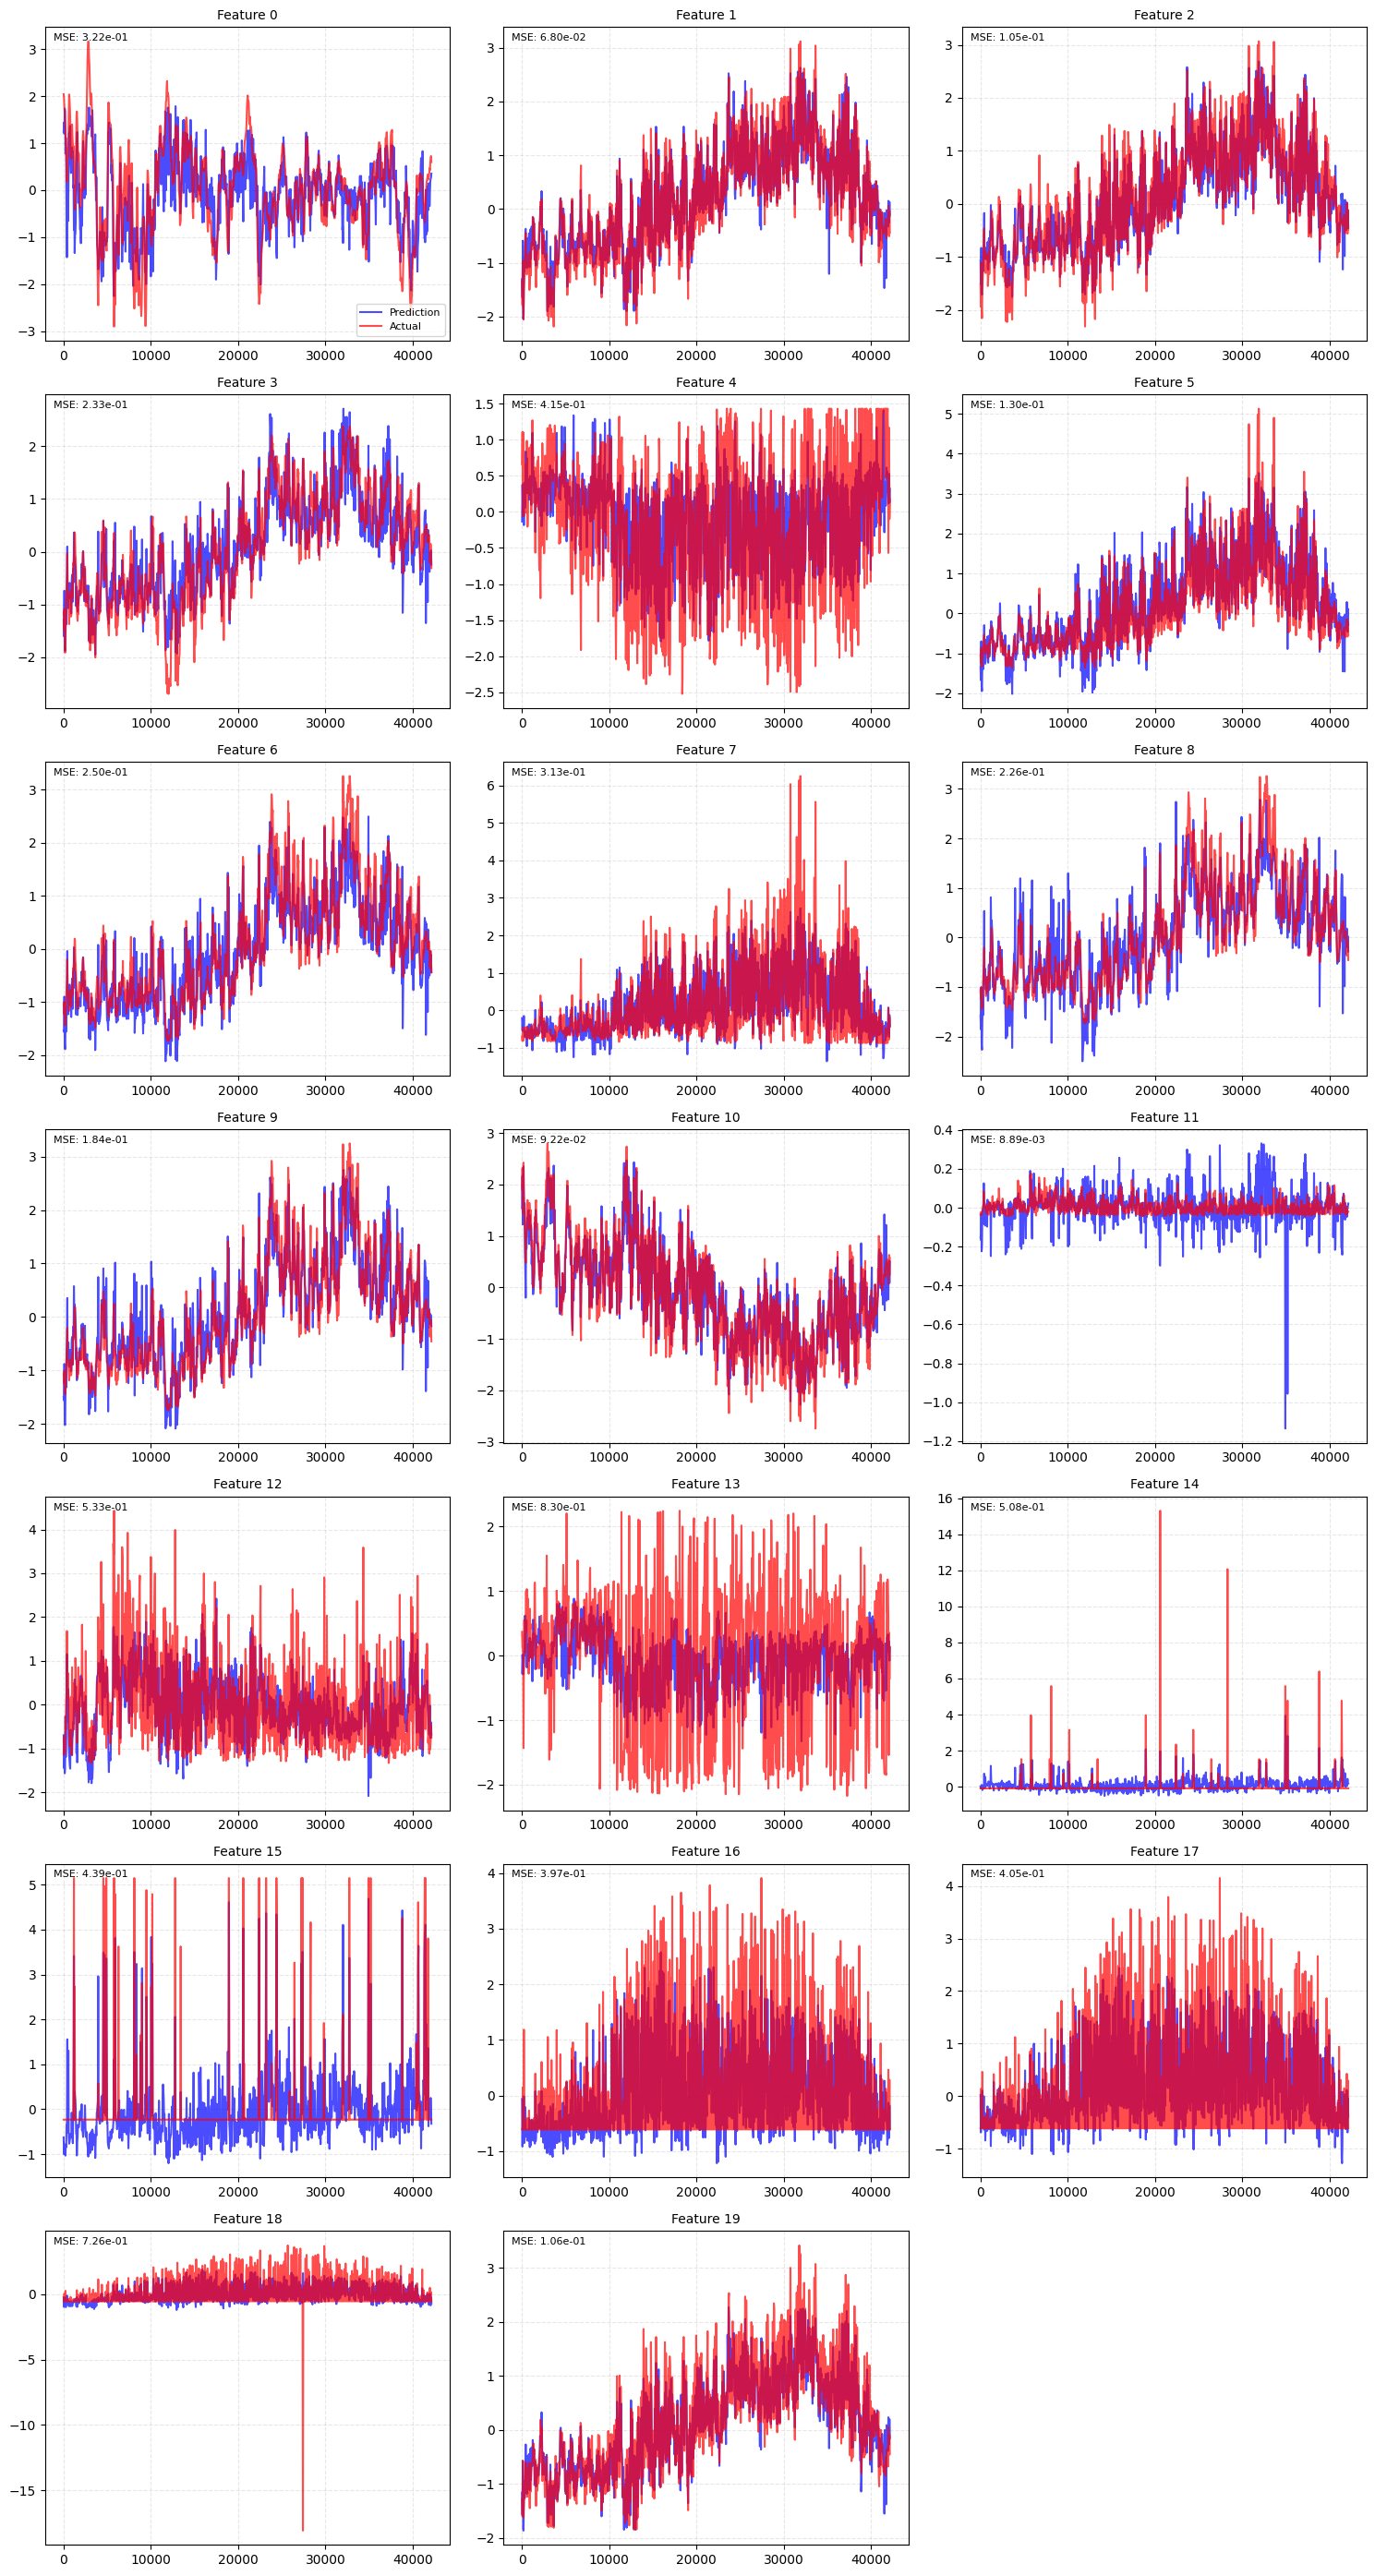


Overall MSE: 3.15e-01


0.31456745

In [9]:
plot_predictions_vs_labels(predictions[:-1], clipped_training)

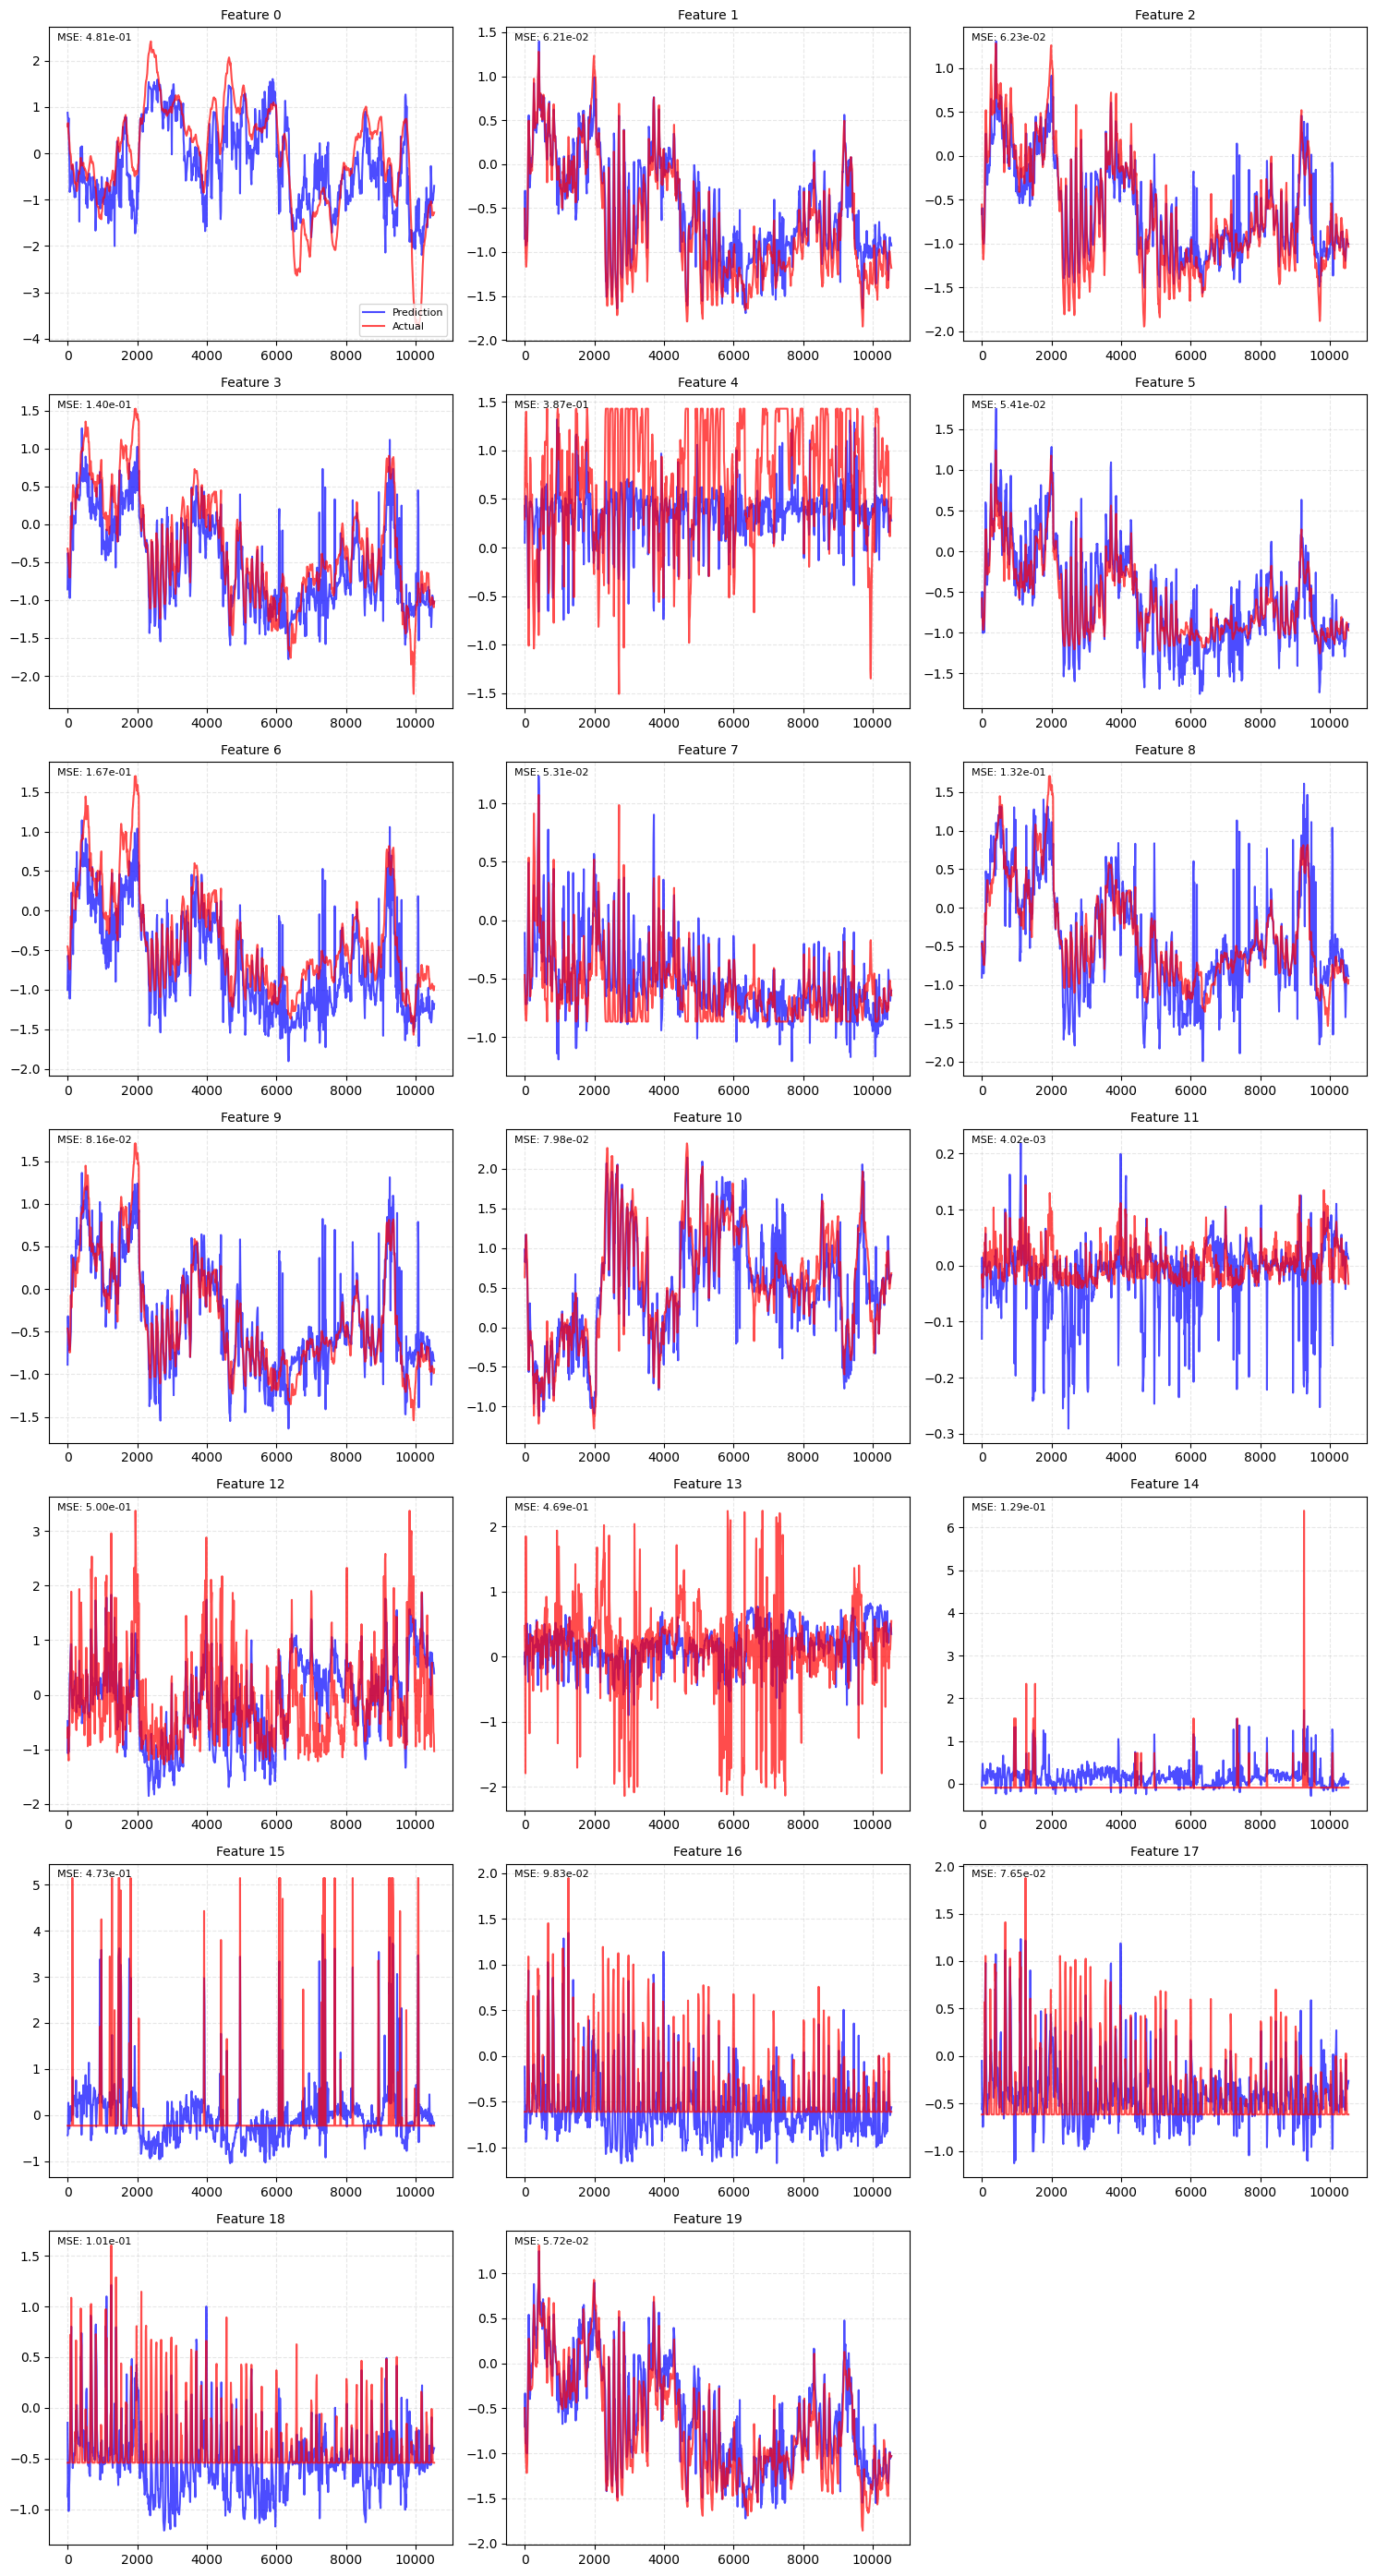


Overall MSE: 1.80e-01


0.18036304

In [10]:
with torch.no_grad():
    val_predictions, val_hidden_sequence = model.forward_input(testing)

plot_predictions_vs_labels(val_predictions[:-1], testing[1:])